<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/OwenHuelU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-rmwlu9yv
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-rmwlu9yv
  Resolved https://github.com/pydata/xarray.git to commit 326dbe78d7ea887c2c242e811b7973661137617f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.2.dev31+g326dbe78-py3-none-any.whl size=1247997 sha256=162e9418f91da9bd2793f63e5233a362ac6aa4ce86db0f67547babb8cde00452
  Stored in directory: /tmp/pip-ephem-wheel-cache-e2o97m2g/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.1
    Uninstalling xarray-2025.1.1:
      Successfully uninstalled xarray-2025.1.1


In [2]:
import xarray as xr

In [3]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.1 MB/s eta 0:00:00


In [4]:
import bambi as bmb

In [5]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

#**Unit 6 Project: Predicting NFL Player Defensive Metrics Using Multiple Predictors**

##**Context**

In the NFL, a sack is a massive play that can end a drive immedietaly. These plays are very impactful, and players who generate a lot of them are often the most sought after in the league. Specifically, a sack is when the Quarterback is tackled behind the line of scrimmage for a loss of yards.

I want to try to predict how many sacks an NFL player might record in a season based on a number of different statistics. I'll be using bambi to create GLMs to carry out the modeling process.

##**Data**

Before we begin to create and test models, here is the raw data and visualization.

In [6]:
#raw data csv from my github
url_nfl = 'https://raw.githubusercontent.com/OwenHuels/data-science/main/nfl24.csv'

nfl = pd.read_csv(url_nfl)

#view data
nfl

,Player,Age,Team,Pos,G,GS,Int,Yds,IntTD,Lng,...,FRTD,Sk,Comb,Solo,Ast,TFL,QBHits,Sfty,Awards,Code
0,Ameer Abdullah,31,LVR,RB,16,3,0,0,0,0,...,0,0.0,4,2,2,0,0,0,NaN,AbduAm00
1,Yasir Abdullah,24,JAX,LB,14,3,0,0,0,0,...,0,0.0,18,14,4,0,1,0,NaN,AbduYa00
2,Micah Abernathy,27,ATL,S,6,0,0,0,0,0,...,0,0.0,3,0,3,0,0,0,NaN,AberMi00
3,Johnathan Abram,28,NOR,S,3,0,1,30,0,30,...,0,0.0,18,10,8,0,0,0,NaN,AbraJo01
4,Kris Abrams-Draine,23,DEN,CB,5,1,1,17,0,17,...,0,0.0,9,5,4,0,0,0,NaN,AbraKr00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,Dareke Young,25,SEA,WR,14,0,0,0,0,0,...,0,0.0,7,6,1,0,0,0,NaN,YounDa02
1501,Olamide Zaccheaus,27,WAS,WR,17,6,0,0,0,0,...,0,0.0,0,0,0,0,0,0,NaN,ZaccOl01
1502,Nick Zakelj,25,SFO,OL,17,2,0,0,0,0,...,0,0.0,0,0,0,0,0,0,NaN,ZakeNi00
1503,Kevin Zeitler,34,DET,G,16,16,0,0,0,0,...,0,0.0,0,0,0,0,0,0,NaN,ZeitKe00


In [7]:
#remove offensive players from the data set
nfl = nfl.query('Pos != "RB" & Pos != "WR" & Pos != "QB" & Pos != "FB" & Pos != "OL" & Pos != "G" & Pos != "C" & Pos != "TE" & Pos != "T" & Pos != "K" & Pos != "LS" & Pos !="P" & Pos != "OT" & Pos != "OG"')
#reset indexes after removal to make the data look nicer
nfl.reset_index(drop=True, inplace=True)
nfl

,Player,Age,Team,Pos,G,GS,Int,Yds,IntTD,Lng,...,FRTD,Sk,Comb,Solo,Ast,TFL,QBHits,Sfty,Awards,Code
0,Yasir Abdullah,24,JAX,LB,14,3,0,0,0,0,...,0,0.0,18,14,4,0,1,0,NaN,AbduYa00
1,Micah Abernathy,27,ATL,S,6,0,0,0,0,0,...,0,0.0,3,0,3,0,0,0,NaN,AberMi00
2,Johnathan Abram,28,NOR,S,3,0,1,30,0,30,...,0,0.0,18,10,8,0,0,0,NaN,AbraJo01
3,Kris Abrams-Draine,23,DEN,CB,5,1,1,17,0,17,...,0,0.0,9,5,4,0,0,0,NaN,AbraKr00
4,Jamal Adams,29,2TM,DB,5,3,0,0,0,0,...,0,0.0,7,4,3,0,0,0,NaN,AdamJa00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,Rock Ya-Sin,28,SFO,CB,13,0,0,0,0,0,...,0,0.0,3,3,0,0,0,0,NaN,Ya-SRo00
1007,Russ Yeast,25,HOU,S,1,0,0,0,0,0,...,0,0.0,1,1,0,0,0,0,NaN,YeasRu00
1008,Isaac Yiadom,28,SFO,CB,17,5,1,11,0,11,...,0,0.0,46,38,8,0,0,0,NaN,YiadIs00
1009,Byron Young,26,LAR,OLB,17,16,0,0,0,0,...,0,7.5,62,34,28,12,13,1,NaN,YounBy01


As you can see, there are a lot of possible combinations of variables that we could choose. I'll make a DAG in order to decide which ones I want to use.

I'm going to include the following columns in my causal inference diagram because I think that they're the ones with the most interesting and related factors:
* Age
* Position (Pos)
* Games (G)
* Games Started (GS)
* Interceptions (Int)
* Passes Defended (PD)
* Forced Fumbles (FF)
* Sacks (Sk)
* Tackles (Comb)
* Tackles for Loss (TFL)
* Quarterback Hits (QBHits)

##**Models**

After drawing my DAG, I think that I want to attempt to predict sacks. I'm going to start with a model just using a log likelihood because I don't really have any knowledge as to which likelihood would be best. The variables that I predicted to have an impact on sacks based on my DAG were age, position, games, games started, tackles, tackles for loss, and quarterback hits. This was the most possible predictors out of any of the variables in my data set, so that's why I chose sacks. I'll start by running a bunch of models with different combinations of these variables and their interactions and hierarchies to see what happens.

Let's start by just throwing all of them in there.

In [8]:
#define the model
model_nfl_all = bmb.Model("Sk ~ Age + Pos + G + GS + Comb + TFL + QBHits", data=nfl)
#fit the model
idata_nfl_all = model_nfl_all.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

<Axes: xlabel='Sk'>

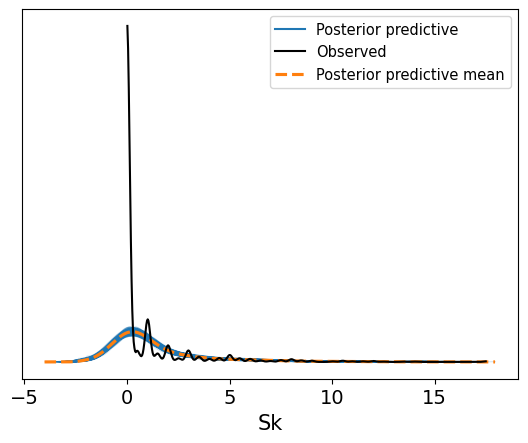

In [9]:
model_nfl_all.predict(idata_nfl_all, kind="response")
az.plot_ppc(idata_nfl_all)

Now let's take away the predictors that I'm less confident are correlated, those being age and games started.

In [10]:
#define the model
model_nfl_noAgeGS = bmb.Model("Sk ~ Pos + G + Comb + TFL + QBHits", data=nfl)
#fit the model
idata_nfl_noAgeGS = model_nfl_noAgeGS.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

I think that age has interactions with both games played and started, so lets add that on to our previous model.

In [11]:
#define the model
model_nfl_intAge = bmb.Model("Sk ~ Pos + G + G:Age + GS + GS:Age + Comb + TFL + QBHits", data=nfl)
#fit the model
idata_nfl_intAge = model_nfl_intAge.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

Another thing worth trying is using position as a hierarchy on tackles for loss and quarterback hits. An edge rusher recording a TFL is a lot more common and expected for the position in comparison to a safety recording one, so there should be a difference in what these variables mean based on position.

In [12]:
#define the model
model_nfl_intAgehierPos = bmb.Model("Sk ~ G + G:Age + GS + GS:Age + Comb + (TFL|Pos) + (QBHits|Pos)", data=nfl)
#fit the model
idata_nfl_intAgehierPos = model_nfl_intAgehierPos.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Now just trying some other stuff to see if any of it produces good results, and if it makes sense.

In [13]:
#define the model
model_nfl_AgeintAgehierPos = bmb.Model("Sk ~ Age + G + G:Age + GS + GS:Age + Comb + (TFL|Pos) + (QBHits|Pos)", data=nfl)
#fit the model
idata_nfl_AgeintAgehierPos = model_nfl_AgeintAgehierPos.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [14]:
#define the model
model_nfl_noGSintAgehierPos = bmb.Model("Sk ~ Age + G + G:Age + Comb + (TFL|Pos) + (QBHits|Pos)", data=nfl)
#fit the model
idata_nfl_noGSintAgehierPos = model_nfl_noGSintAgehierPos.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [15]:
#define the model
model_nfl_noAgeGSintAgehierPos = bmb.Model("Sk ~ G + G:Age + Comb + (TFL|Pos) + (QBHits|Pos)", data=nfl)
#fit the model
idata_nfl_noAgeGSintAgehierPos = model_nfl_noAgeGSintAgehierPos.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [16]:
#define the model
model_nfl_noAgeGSintAgehierPos2 = bmb.Model("Sk ~ G + G:Age + (Comb|Pos) + (TFL|Pos) + (QBHits|Pos)", data=nfl)
#fit the model
idata_nfl_noAgeGSintAgehierPos2 = model_nfl_noAgeGSintAgehierPos2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

I realize that since sacks are a discrete, strictly positive metric, I should probably not be using a normal distribution to model it. I'm going to switch to using a negative binomial family to account for these facts. We'll see if it makes the elpd_loos better.

In [17]:
#define the model
model_nfl_noAgeGSintAgehierPosNegBinomial = bmb.Model("Sk ~ G + G:Age + (Comb|Pos) + (TFL|Pos) + (QBHits|Pos)", data=nfl, family = "negativebinomial")
#fit the model
idata_nfl_noAgeGSintAgehierPosNegBinomial = model_nfl_noAgeGSintAgehierPosNegBinomial.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

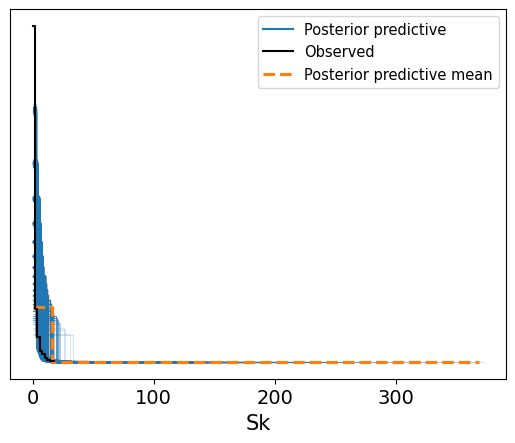

In [18]:
model_nfl_noAgeGSintAgehierPosNegBinomial.predict(idata_nfl_noAgeGSintAgehierPosNegBinomial, kind="response")
ax = az.plot_ppc(idata_nfl_noAgeGSintAgehierPosNegBinomial)

In [19]:
#define the model
model_nfl_Comb = bmb.Model("Sk ~ Comb", data=nfl, family = "negativebinomial")
#fit the model
idata_nfl_Comb = model_nfl_Comb.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

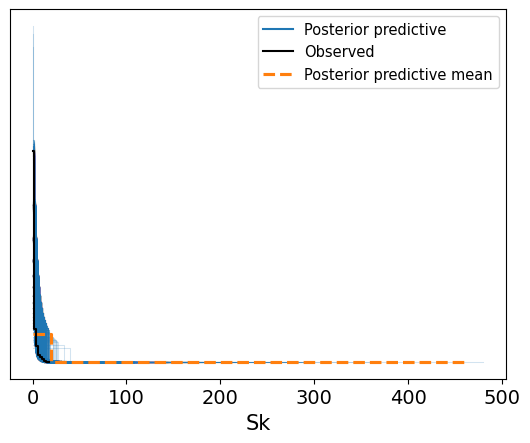

In [20]:
model_nfl_Comb.predict(idata_nfl_Comb, kind="response")
ax = az.plot_ppc(idata_nfl_Comb)

In [21]:
#define the model
model_nfl_Hits = bmb.Model("Sk ~ (Comb|Pos) + (TFL|Pos) + (QBHits|Pos)", data=nfl, family="negativebinomial")
#fit the model
idata_nfl_Hits = model_nfl_Hits.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

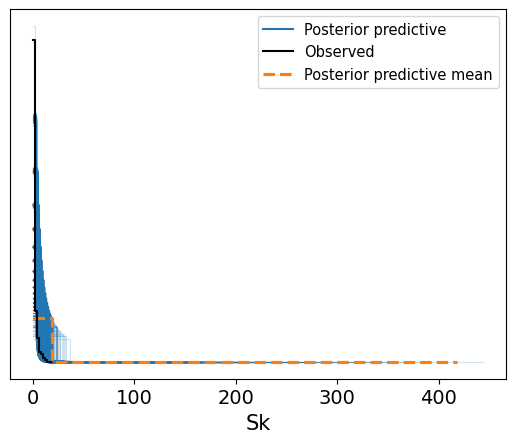

In [22]:
model_nfl_Hits.predict(idata_nfl_Hits, kind="response")
ax = az.plot_ppc(idata_nfl_Hits)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Comb', ylabel='Sk'>], dtype=object))

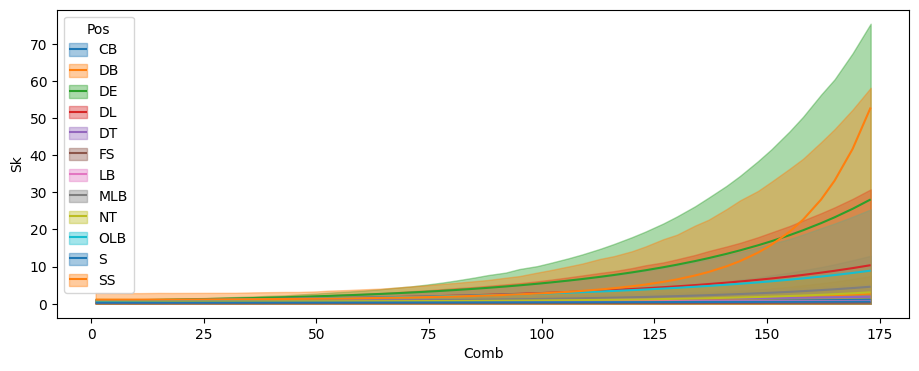

In [23]:
bmb.interpret.plot_predictions(model_nfl_Hits,
                               idata_nfl_Hits,
                               ["Comb","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

In [24]:
#define the model
model_nfl_CombPos = bmb.Model("Sk ~ Comb + TFL + QBHits + Comb:Pos + TFL:Pos + QBHits:Pos", data=nfl, family = "negativebinomial")
#fit the model
idata_nfl_CombPos = model_nfl_CombPos.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [25]:
cmp_df_bmb = az.compare( {"All":idata_nfl_all,"No Age or Games Started":idata_nfl_noAgeGS,
                          "Interact Age":idata_nfl_intAge,"Hierarchy Position":idata_nfl_intAgehierPos,
                          "Interact and Hierarchy plus Age":idata_nfl_AgeintAgehierPos,
                          "Interact and Hierarcy minus Games Started":idata_nfl_noGSintAgehierPos,
                          "Interact and Hierarchy minus Age and Games Started":idata_nfl_noAgeGSintAgehierPos,
                          "Interact and Hierarchy minus Age and Games Started 2":idata_nfl_noAgeGSintAgehierPos2,
                          "Interact and Hierarchy minus Age and Games Started NegBinomial":idata_nfl_noAgeGSintAgehierPosNegBinomial,
                          "Tackles":idata_nfl_Comb,"Hits":idata_nfl_Hits,"Tackles and Position":idata_nfl_CombPos} )
cmp_df_bmb

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Interact and Hierarchy minus Age and Games Started NegBinomial,0,-968.067111,35.179488,0.000000,7.511217e-01,34.036757,0.000000,True,log
Hits,1,-976.566805,33.912344,8.499694,0.000000e+00,33.401897,5.181566,True,log
Tackles and Position,2,-1022.121041,33.448740,54.053929,3.947236e-12,34.308654,10.218898,True,log
Interact and Hierarchy minus Age and Games Started 2,3,-1191.822656,79.321765,223.755544,2.005801e-01,52.294592,44.592415,True,log
Interact and Hierarcy minus Games Started,4,-1197.107125,70.100068,229.040014,0.000000e+00,50.690070,43.909945,True,log
Interact and Hierarchy minus Age and Games Started,5,-1198.162776,71.064704,230.095664,4.571794e-02,51.084924,44.189814,True,log
Hierarchy Position,6,-1200.512011,73.762331,232.444900,0.000000e+00,51.478551,44.443805,True,log
Interact and Hierarchy plus Age,7,-1201.021322,74.232866,232.954211,2.134813e-13,51.233153,44.299417,True,log
No Age or Games Started,8,-1243.443364,31.580234,275.376253,0.000000e+00,48.905886,42.527555,True,log
All,9,-1243.980557,33.325636,275.913446,2.190225e-13,48.831406,42.450623,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

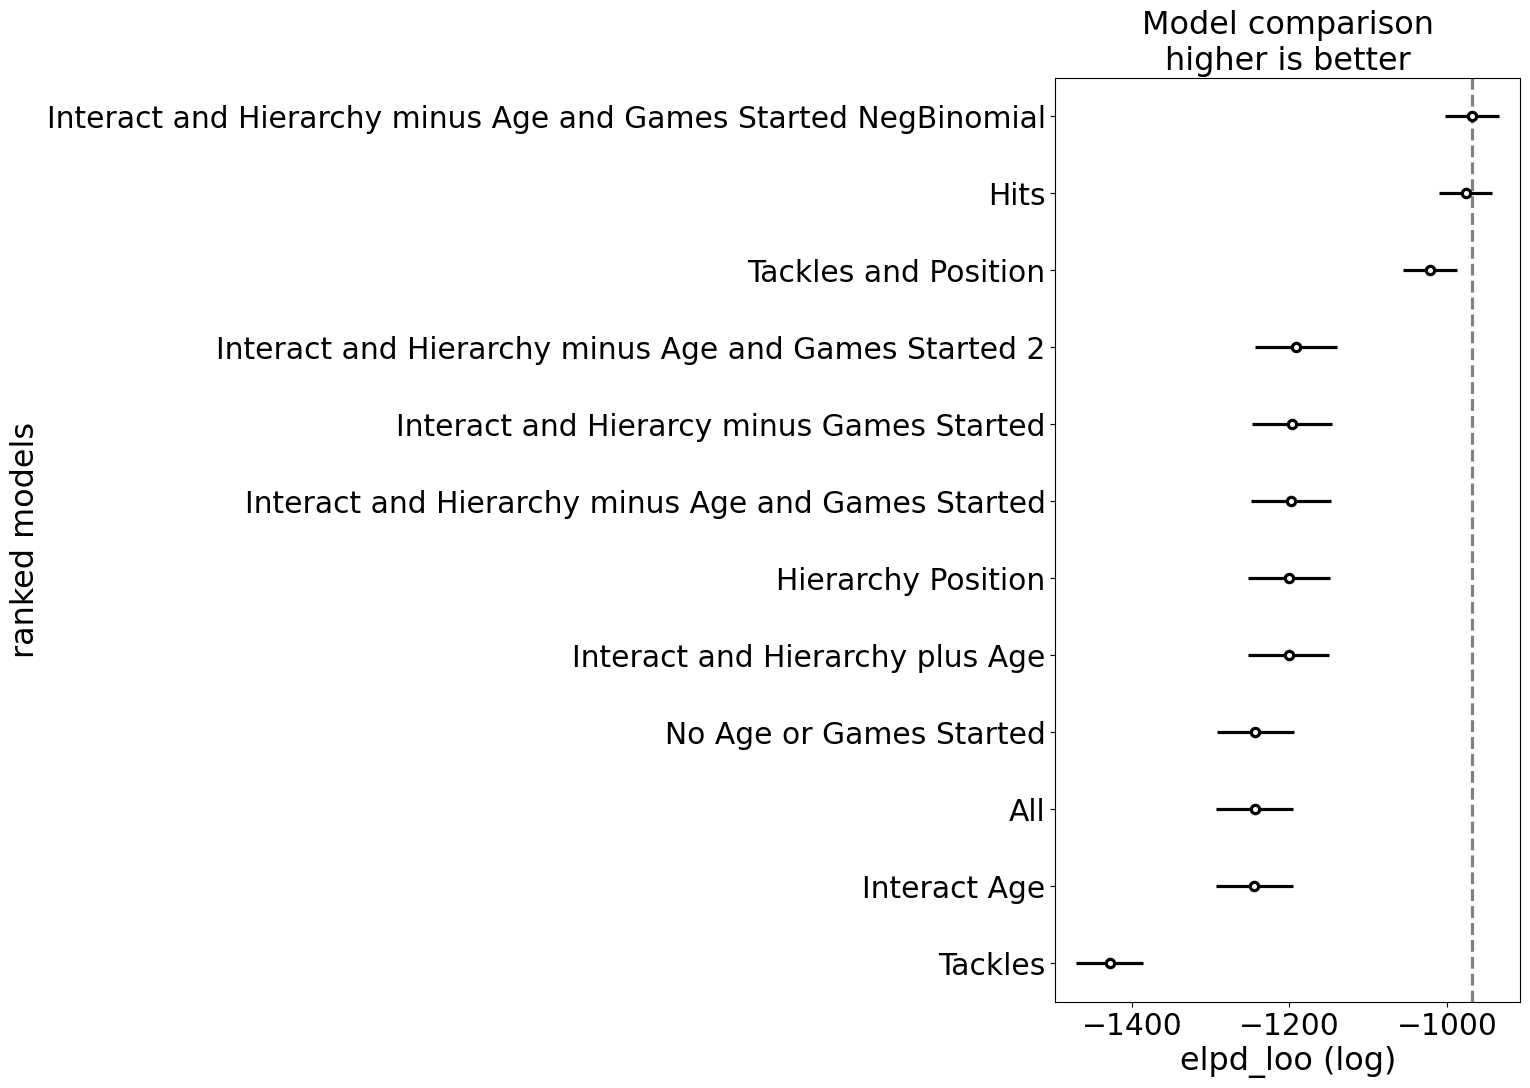

In [26]:
az.plot_compare(cmp_df_bmb)

In [40]:
#define the model
model_nfl_Hits2 = bmb.Model("Sk ~ (Comb|Pos) + (TFL|Pos) + (QBHits|Pos)", data=nfl, family="negativebinomial")
#fit the model
idata_nfl_Hits2 = model_nfl_Hits2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

Here is a figure showing sack numbers by position, with total tackles as the individual bars on each position. As you can see, the rushing positions (DE, DL, and OLB) have the observed data very well predicted by the model, while secondary positions are more difficult for the model to predict. Generally, the more total tackles a player has, the more sacks they have. This trend is more prevalent in the positions mentioned above, which is why they appear steeper.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


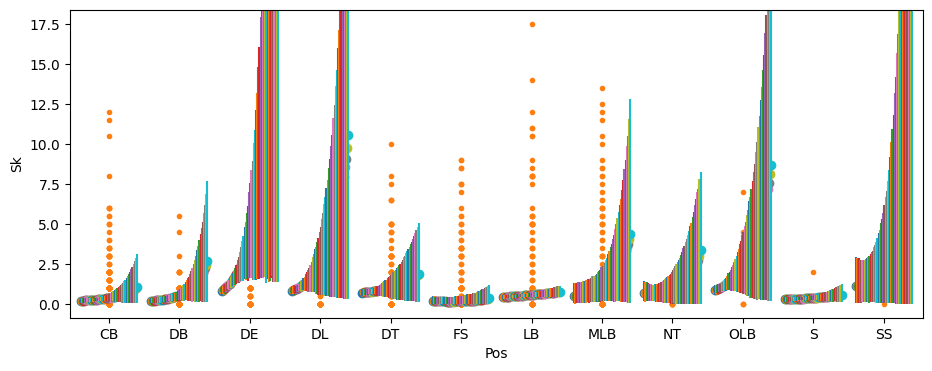

In [70]:
#plt.plot(nfl.QBHits, nfl.Sk, "C1.", zorder=-3)
bmb.interpret.plot_predictions(model_nfl_Hits2,
                               idata_nfl_Hits2,
                               ["Pos", "Comb"],
                               fig_kwargs={"figsize":(11, 4)},
                               legend=False)
plt.plot(nfl.Pos, nfl.Sk, "C1.", zorder=-3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Comb', ylabel='Sk'>], dtype=object))

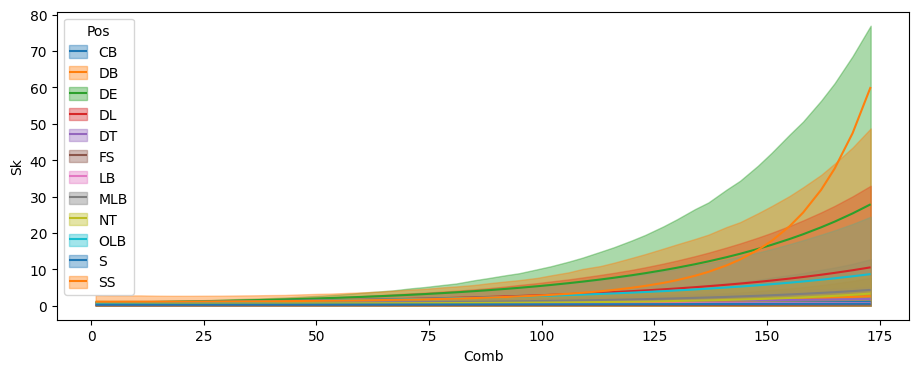

In [72]:
bmb.interpret.plot_predictions(model_nfl_Hits2,
                               idata_nfl_Hits2,
                               ["Comb","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

##**Conclusion**

Based on the elpd_loo and the posterior predictive, I'd say the model using total tackles, tackles for loss, and quarterback hits, all with a categorical hierarchy based on position, is probably the best model. This is the model named "Hits" in the list of elpd_loos. It has the second highest elpd_loo, very close to that the best performing model. I selected this model over the top performing one to avoid overfitting; the top one is this model plus games and an interaction term between games and age, so it has more variables than needed. I think these terms didn't matter too much because more tackles, tfls, and qbhits correlates pretty closely to games played, so that information is already captured in those statistics. This model also uses a negative binomial family, which I realized I should have been using about halfway through because sacks are discrete data, they're only recorded in intervals of 0.5.

The hierarchy based on position is very important for this model to run well because defensive position has a large impact on what correlation sacks has to total tackles and tfl especially. For example, a defensive end or defensive lineman usually gets tfls on either running backs or the quarterback, and both of these are good indicators that the player is generating pressure in the pocket that could lead to a sack. On the other hand, tfls by defensive backs or safeties usually occur when a lateral pass is thrown and then the receiver is immedietaly tackled behind the line of scrimmage. Both examples result in a tfl, but the DB and safety didn't make a play that could have easily been a sack.

From observing the plot of the model I ended up going with, it seems like the strongest predictor for sacks is total tackles, which makes sense. This correlation is strongest for defensive ends, defensive linemen, and outside linebackers. These three position are the ones that start on the line and attempt to rush the quarterback, so any tackles they get are pretty possible to have been a sack. That's why the correlation is so strong for them. The model, from looking at the visualization above, does a lot better job of capturing trends in defensive lineman, outside linebacker, and defensive end sack data over any other position. This is because these players consistently get after the quarterback on every play versus just have random one off sacks for secondary players, so it's a lot easier to consistently predict their numbers.

If I ran more models in the future, I would want to get some data on pressures by defensive players as well. Pressures are when a rusher gets through the offensive line and forces the quarterback to make a move. This isn't recorded as a tfl or qbhit because the player never actually contacts the quarterback, but it's a good indicator that a player is getting a bunch of chances to get sacks if they're getting a lot of pressures. Something else I might want to change is altering player positions a bit more, because there's a couple players whose position is listed as strong safety or free safety rather than just safety, which are really all very similar positions that could be lumped into just safety. This would help clean up the outliers a lot and make the trend more obvious for these positions with only a couple players. I could also just run the model with only primary defensive players (no safeties or corners), so that I'm only looking at players who would realistically record sacks.